# Shuffle the categorical feature

In [4]:
import os 
#if you want to know current working dir
os.getcwd()
os.chdir('/home/jecosine/Courses/Courses/COMP8800/Projects/CatBoostPlayground')
os.listdir()

from allib.datasets import load_uci, AVAIL_DATASETS
import pandas as pd
import numpy as np
from allib.models import get_pipeline, AVAIL_MODELS
from allib.models.al import get_al_strategy
from allib.metrics import get_metrics
import pickle
import matplotlib.pyplot as plt
from allib.plots import PLMetric
from allib.metrics import distance

RP = "/home/jecosine/Courses/Courses/COMP8800/Projects/CatBoostPlayground/examples"


In [5]:
def load_ds(name: str):
    ds = load_uci(name)
    ds.with_preprocess(
        steps=[
            "sample_n", 
            "continuous_to_categorical", 
            "remove_constant_columns", 
            "drop_duplicate_rows"
        ],  
        params_list=[
            {"n": 1000, "random_state": 0},
            {"encode": "ordinal"}, 
            {}, 
            {}
        ], 
        in_place=True
    )
    return ds

make_ppl = get_pipeline('catboost')
stg = get_al_strategy("random")

In [11]:
iris = iris.with_strategy(stg)
ppl = make_ppl(
    model=None,
    eval_metrics=get_metrics(["accuracy"]),
    seeds=[i for i in range(20)],
    n_times=20,
    dataset=iris,
    cat_idx=iris.info["cat_idx"]
)
ppl.start()

NameError: name 'iris' is not defined

In [16]:
with open("ppl_cache@random_cat/iris@kbin@numberic@random@x20.pkl", "wb") as f:
    pickle.dump(ppl.stats, f)

In [23]:
iris2 = iris.with_strategy(stg)
for col in iris2._data.columns:
    iris2._data[col] = iris2._data[col].apply(lambda x: 'nn'+str(x))
ppl = make_ppl(
    model=None,
    eval_metrics=get_metrics(["accuracy"]),
    seeds=[i for i in range(20)],
    n_times=20,
    dataset=iris2,
    cat_idx=iris2.info["cat_idx"]
)
ppl.start()
with open("ppl_cache@random_cat/iris@kbin@cat@random@x20.pkl", "wb") as f:
    pickle.dump(ppl.stats, f)

100%|██████████| 20/20 [12:46<00:00, 38.34s/it]


## Plotting

In [31]:
with open("ppl_cache@random_cat/iris@kbin@numberic@random@x20.pkl", "rb") as f:
    stats1 = pickle.load(f)
    
with open("ppl_cache@random_cat/iris@kbin@cat@random@x20.pkl", "rb") as f:
    stats2 = pickle.load(f)
    
metrics_n_times = [
    [stats1[i]["accuracy"] for i in range(len(stats1))],
    # [stats2[i]["accuracy"] for i in range(len(stats2))],
]
instances = stats1[0]["instances"]
pl_metric = PLMetric(output_path="plots@random_cat")
pl_metric.plot("Accuracy", instances, np.array(metrics_n_times), ["cat"], plot_name="test.png", cmap=plt.get_cmap("Paired"), dpi=300, title=f"Accuracy iris@catboost@cat_num", errorbar="std")


## test batch size

In [19]:
from allib.utils.fs import ensure_path


model_extra_params = { "iterations": 100 }
dsn = "adult"
dataset = load_ds(dsn)
dataset.with_preprocess(
    steps=[
        "sample_n", 
        "remove_constant_columns", 
        "drop_duplicate_rows"
    ],  
    params_list=[
        {"n": 1000, "random_state": 0},
        {}, 
        {}
    ], 
    in_place=True
)
test_bs_list = [1, 5, 10, 50, 100]
total = 100
STRATEGY = "typiclust"
metric = "euclidean"
DIST_CACHE = "examples/dist_cache"
ENCODE = "ordinal"

stg = get_al_strategy(STRATEGY)
for bs in test_bs_list:
    fn = f"{DIST_CACHE}/{dsn}/{metric}_ordinal.npy"
    # if ensure_path(os.path.join(LOCAL_DIR, "ppl_cache_pred", cache_name), False):
    #     print(f"exp {cache_name} already exists, continue")
    #     continue
    if not ensure_path(fn, False):
        print(f"{metric} for {dsn} not found in {fn}, skipping ...")
        continue
    print(f"Using cache of {metric} for {dsn} with {ENCODE} encoding")
    setattr(stg, "dist_cache_path", fn)
    dataset.batch_size = bs
    ds = dataset.with_strategy(stg, extra_params={"distance_metric": metric})
    # ds.batch_size = bs
    ppl = make_ppl(
        model=None,
        # eval_metrics=get_metrics(["accuracy"]),
        eval_metrics=get_metrics([]),
        seeds=[i for i in range(20)],
        n_times=20,
        dataset=ds,
        cat_idx=ds.info["cat_idx"],
        early_stop=int(total // bs) + 1,
        model_extra_params=model_extra_params
    )
    ppl.start()
    print(f"running batch size: {bs}")
    with open(os.path.join(RP, f"ppl_cache_pred@random_cat/adult@kbin@numberic@{STRATEGY}@x20@bs{bs}.pkl"), "wb") as f:
        pickle.dump(ppl.stats, f)


/home/jecosine/anaconda3/envs/COMP8800/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/jecosine/anaconda3/envs/COMP8800/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/jecosine/anaconda3/envs/COMP8800/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/jecosine/anaconda3/envs/COMP8800/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the numbe

Using cache of euclidean for adult with ordinal encoding
[WARNING] Start without evaluating metrics


100%|██████████| 20/20 [07:25<00:00, 22.26s/it]


running batch size: 1
Using cache of euclidean for adult with ordinal encoding
[WARNING] Start without evaluating metrics


100%|██████████| 20/20 [01:40<00:00,  5.02s/it]


running batch size: 5
Using cache of euclidean for adult with ordinal encoding
[WARNING] Start without evaluating metrics


100%|██████████| 20/20 [00:55<00:00,  2.80s/it]


running batch size: 10
Using cache of euclidean for adult with ordinal encoding
[WARNING] Start without evaluating metrics


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


running batch size: 50
Using cache of euclidean for adult with ordinal encoding
[WARNING] Start without evaluating metrics


100%|██████████| 20/20 [00:11<00:00,  1.78it/s]

running batch size: 100


/home/jecosine/anaconda3/envs/COMP8800/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/jecosine/anaconda3/envs/COMP8800/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/jecosine/anaconda3/envs/COMP8800/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/jecosine/anaconda3/envs/COMP8800/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the numbe

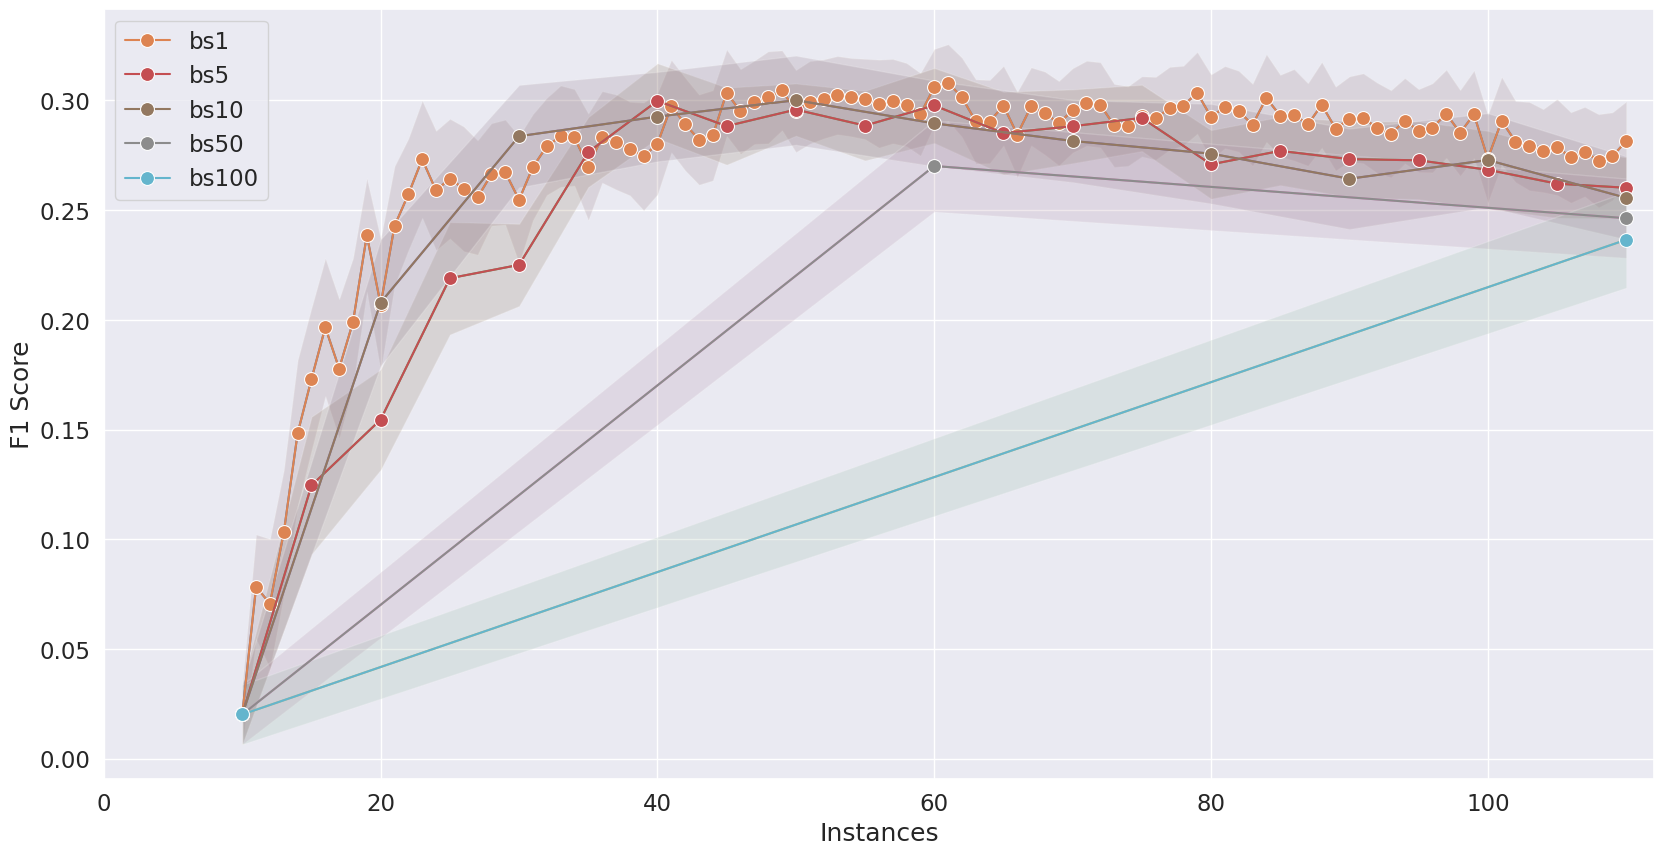

In [15]:
from sklearn.metrics import f1_score
import seaborn as sns
sns.set(font_scale=1.5)
test_bs_list = [1, 5, 10, 50, 100]
ds = load_ds("adult")
fig, ax = plt.subplots(figsize=(20, 10))
pl_metric = PLMetric(ax=ax, output_path="plots@random_cat")
for bs in test_bs_list:
    metrics_n_times = []
    instances = []
    with open(os.path.join(RP, f"ppl_cache_pred@random_cat/adult@kbin@numberic@typiclust@x20@bs{bs}.pkl"), "rb") as f:
        stats = pickle.load(f)
        metrics_n_times.append([[f1_score(ds.test_y, stats[i]["predictions"][j], pos_label=">50K") for j in range(len(stats[i]["instances"]))] for i in range(len(stats))]) 
        # metrics_n_times.append([stats[i]["accuracy"] for i in range(len(stats))])
        instances = stats[0]["instances"]
    # print(np.array(metrics_n_times).shape)
    x = instances
    med, mx, mn = pl_metric.errorbar("std", np.array(metrics_n_times[0]))
    ax = sns.lineplot(x=x, y=med)
    ax.fill_between(x, mn, mx, alpha=0.1)
    ax = sns.lineplot(x=x, y=med, label=f"bs{bs}", marker="o", markersize=10)
    ax.fill_between(x, mn, mx, alpha=0.1)

    # ax.plot(x, med, label=f"bs{bs}", marker="o", markersize=5)
    ax.set_xlabel("Instances")
    ax.set_ylabel(f"F1 Score")
    ax.legend()
    # pl_metric.plot("F1 Score", instances, np.array(metrics_n_times), [f"bs{bs}"], plot_name=f"test_bs{bs}.png", dpi=300, title=f"F1 Score adult@catboost@cat_num", errorbar="std")
ax.set_xlim(0, 112)
plt.savefig(f"examples/plots@random_cat/adult@catboost@typiclust@bs1-5-10-50-100.png")

In [15]:
np.array(metrics_n_times).mean(axis=1)

array([[0.4925, 0.52  , 0.5575, 0.6825, 0.73  , 0.73  , 0.765 , 0.8125,
        0.8025, 0.825 , 0.7825, 0.8125],
       [0.4925, 0.52  , 0.5575, 0.6825, 0.73  , 0.73  , 0.765 , 0.8125,
        0.8025, 0.825 , 0.7825, 0.8125],
       [0.4925, 0.52  , 0.5575, 0.6825, 0.73  , 0.73  , 0.765 , 0.8125,
        0.8025, 0.825 , 0.7825, 0.8125],
       [0.4925, 0.52  , 0.5575, 0.6825, 0.73  , 0.73  , 0.765 , 0.8125,
        0.8025, 0.825 , 0.7825, 0.8125],
       [0.4925, 0.52  , 0.5575, 0.6825, 0.73  , 0.73  , 0.765 , 0.8125,
        0.8025, 0.825 , 0.7825, 0.8125]])

In [10]:
metrics_n_times = []
instances = []
for bs in range(1, 11):
    with open(os.path.join(RP, f"ppl_cache@random_cat/iris@kbin@numberic@random@x20@bs{bs}.pkl"), "rb") as f:
        stats2 = pickle.load(f)
        metrics_n_times.append(np.array([stats2[i]["accuracy"] for i in range(len(stats2))]))
        instances.append(stats2[0]["instances"])
pl_metric = PLMetric(output_path=os.path.join(RP, "plots@random_cat"))
pl_metric.plot("Accuracy", instances=instances, metrics_n_times=metrics_n_times, strategies=[str(i) for i in range(1, 11)], plot_name="bs_adult.png", cmap=plt.get_cmap("Paired"), dpi=300, title=f"Accuracy adult@catboost@batch_size", errorbar="std", multi_x=True)

In [ ]:
for ds in AVAIL_DATASETS:
    metrics_n_times = []
    for metric in distance.AVAIL_DIST_METRICS:
        fn = f"{DIST_CACHE}/{dsn}/{metric}_{ENCODE}.npy"
        cache_name = f"{dsn.replace('/', '_')}@{model_name}@{ALSTRATEGY}_{metric}_{ENCODE}@{SUFFIX}@x20.pkl"
        